# Optimization Tutorial

Trey V. Wenger (c) July 2024

Here we demonstrate how to optimize the number of cloud components in a `bayes_spec` model.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.3.0


## Model Definition and Simulated Data

Like in the basic tutorial for `GaussLineNoise`, our model is a Gaussian line profile with the spectral noise as a free parameter. We generate synthetic data as in the basic tutorial, and the data key must be `"observation"` for this model.

Text(0, 0.5, 'Brightness Temperature (K)')

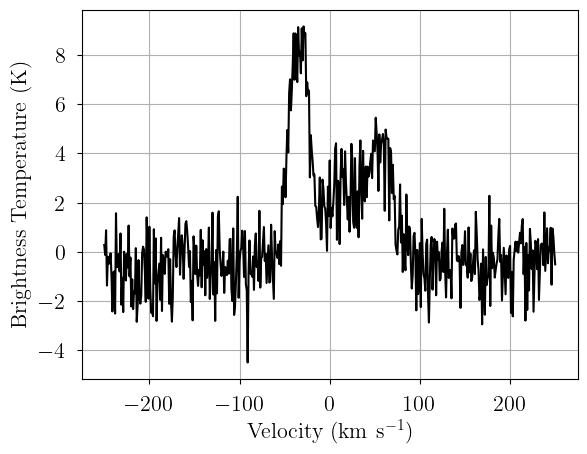

In [2]:
from bayes_spec import SpecData
from bayes_spec.models import GaussLineNoise

# Generate dummy data format for simulation
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s
noise = 1.0 # K
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Initialize and define the model
model = GaussLineNoise(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "rms_observation": 1.0, # spectral rms (K)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [3]:
# Pack simulated data into SpecData
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    GaussLineNoise,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=3,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 3.010e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,183.9


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.008e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 3300
Interrupted at 3,299 [3%]: Average Loss = 1,098.4


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.636e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 1,168.7


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.609e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,364.6


No solution found!
GMM found 0 unique solutions

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 1900
Interrupted at 1,899 [1%]: Average Loss = 1,852.1


No solution found!
GMM found 0 unique solutions

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 1,168.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Only 3 chains appear converged.
GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
display(az.summary(opt.best_model.trace.solution_0))

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.144,0.395,8.356,9.868,0.009,0.007,1887.0,1661.0,1.0
amplitude[1],3.080,0.291,2.490,3.577,0.006,0.004,2282.0,2869.0,1.0
amplitude[2],4.487,0.557,3.322,5.352,0.018,0.013,1100.0,1661.0,1.0
fwhm[0],25.499,1.220,23.347,27.914,0.028,0.020,1866.0,2207.0,1.0
fwhm[1],48.163,14.555,25.470,75.983,0.514,0.364,835.0,1406.0,1.0
fwhm[2],32.821,4.209,25.266,41.262,0.129,0.092,1040.0,1519.0,1.0
fwhm_norm[0],0.850,0.041,0.778,0.930,0.001,0.001,1866.0,2207.0,1.0
fwhm_norm[1],1.605,0.485,0.849,2.533,0.017,0.012,835.0,1406.0,1.0
fwhm_norm[2],1.094,0.140,0.842,1.375,0.004,0.003,1040.0,1519.0,1.0
line_area[0],248.189,15.897,217.164,276.619,0.464,0.328,1194.0,1659.0,1.0


With `approx=False`, the optimization algorithm samples each model with MCMC (or SMC if `smc=True`) and determines which is the first model with a BIC within `bic_threshold` of the minimum across all models. This is more accurate, but slower. Be careful not to set `max_n_clouds` too high!

In [8]:
opt.optimize(sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 3.010e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,183.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.001e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3300
Interrupted at 3,299 [3%]: Average Loss = 1,098.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Only 3 chains appear converged.
GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.635e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 1,168.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Only 3 chains appear converged.
GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.606e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,364.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


There were 2 divergences in converged chains.
GMM converged to unique solution
Chain label order mismatch in solution 0
Chain 2 order: [0 1 3 2]
Chain 3 order: [0 2 3 1]
Adopting (first) most common order: [0 1 3 2]
n_cloud = 4 solution = 0 BIC = 5.093e+03

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 1900
Interrupted at 1,899 [1%]: Average Loss = 1,852.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.


Only 3 chains appear converged.
No solution found!
GMM found 0 unique solutions



Notice that models with more complexity than is present in the data (i.e., `n_clouds` > the true number of clouds) tend to have more divergences and difficulty converging.

In [9]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
display(az.summary(opt.best_model.trace.solution_0))

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.144,0.395,8.356,9.868,0.009,0.007,1887.0,1661.0,1.0
amplitude[1],3.080,0.291,2.490,3.577,0.006,0.004,2282.0,2869.0,1.0
amplitude[2],4.487,0.557,3.322,5.352,0.018,0.013,1100.0,1661.0,1.0
fwhm[0],25.499,1.220,23.347,27.914,0.028,0.020,1866.0,2207.0,1.0
fwhm[1],48.163,14.555,25.470,75.983,0.514,0.364,835.0,1406.0,1.0
fwhm[2],32.821,4.209,25.266,41.262,0.129,0.092,1040.0,1519.0,1.0
fwhm_norm[0],0.850,0.041,0.778,0.930,0.001,0.001,1866.0,2207.0,1.0
fwhm_norm[1],1.605,0.485,0.849,2.533,0.017,0.012,835.0,1406.0,1.0
fwhm_norm[2],1.094,0.140,0.842,1.375,0.004,0.003,1040.0,1519.0,1.0
line_area[0],248.189,15.897,217.164,276.619,0.464,0.328,1194.0,1659.0,1.0


With posteriors sampled with MCMC, we can also use leave-one-out cross-validation to perform model comparison.

In [10]:
# Populate models with likelihood samples
for model in opt.models.values():
    with model.model:
        pm.compute_log_likelihood(model.trace)

Output()

Output()

Output()

Output()

Output()

In [11]:
# leave-one-out cross validation
loo = az.compare({n_gauss: model.trace for n_gauss, model in opt.models.items()})
display(loo)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
3,0,-757.771762,12.913655,0.000000,0.93878,14.893397,0.000000,False,log
4,1,-758.635739,13.637982,0.863977,0.00000,14.863208,0.308273,False,log
5,2,-758.767963,14.188124,0.996201,0.00000,14.916222,0.496898,False,log
2,3,-783.666815,10.477643,25.895053,0.06122,14.602278,7.749143,False,log
1,4,-975.736014,8.554295,217.964252,0.00000,20.412370,21.763940,False,log


The model with the largest `elpd_loo` is preferred.

Sampling: [observation]


Output()

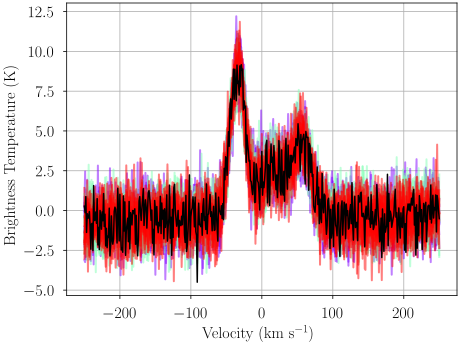

In [12]:
posterior_predictive = opt.best_model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_opt.{ext}"
)
SVG(f"{figdir}/posterior_predictive_opt.{ext}")